# Put TNG data into format for cosmic integration with COMPAS

Cosmic integration in COMPAS currently uses analytical model for SFR (M&D 14) and for the metallicity distribution (skewed log normal, based on Neijssel+ 19). There are 4 SFR parameters and 5 dP/dlogZ parameters.

The SFR is calculated using the find_sfr function, which needs the redshifts as a list of floats at which the SFR will be evaluated, and the 4 parameters a,b,c,d. The SFR is then returned as a list of floats (corresponding to each redshift), in units of M_$\odot$/Gpc$^3$/yr.

The metallicity distribution (dP/dlogZ) is calculated using the find_metallicity_distribution function which needs both COMPAS information, the metallicity distribution parameters ($\mu_0, \mu_z, \omega_0, \omega_z, \alpha$), the redshifts as a list of floats, and minimum and maximum logZ and the step size in logZ. 
- The metallicities at which dP/dlogZ is calculated at is calculated from the min, max, and step size of logZ. Then take the exponent to get the metallicities which are returned. dP/dlogZ is calculated using logZ. 
- The list of redshifts is used to calculate the mean metallicities and the log-Linear redshift dependence of sigma. When using the model, the mean metallicities ($\mu$) are calculated from $\mu_0$ and $\mu_z$ and the variance ($\omega$) is calculated from $\omega_0$ and $\omega_z$.

In [302]:
import sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns

from scipy import interpolate
from astropy.cosmology import Planck15  as cosmo# Planck15 since that's what TNG uses
from astropy.cosmology import z_at_value
from IPython.display import Image # to open images in Ipython 
from scipy.stats import norm as NormDist

############################
# Custom scripts
sys.path.append('../')
import get_ZdepSFRD as Z_SFRD
import importlib
import paths

In [303]:
#Change file names to match TNG version
tng=50
ver = 1
Cosmol_sim_location = paths.data / str("SFRMetallicityFromGasTNG%s-%s.hdf5"%(tng,ver))
fit_filename = 'test_best_fit_parameters_TNG%s-%s.txt'%(tng,ver)
if tng==50:
    rbox=35
elif tng==100:
    rbox=75
elif tng==300:
    rbox=205
SFRD_Z_z_fname = 'SFRD_TNG%s-%s.txt'%(tng,ver)
metals_fname = 'metallicities_TNG.txt'
Zsun = 0.014 # Solar metallicity
cmap = sns.color_palette('rocket', as_cmap=True)

In [304]:
def find_sfr(redshifts, a = 0.01, b =2.77, c = 2.90, d = 4.70):
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr #sfr.to(u.Msun / u.yr / u.Gpc**3).value

In [305]:
def find_metallicity_distribution(redshifts, metals = [], min_logZ_COMPAS = np.log(1e-4), max_logZ_COMPAS = np.log(0.03),
                                  mu_0=0.025, mu_z=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01):
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)

    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts)

    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma)
    mu_metallicities = np.log(mean_metallicities/(2.*PHI)) - (sigma**2)/2.
    
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities     = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)[0]

    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) \
    * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) \
    * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    # normalise the distribution over all metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, step_logZ, p_draw_metallicity

### Read TNG data

In [306]:
Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG(loc = Cosmol_sim_location, rbox=rbox)

In [307]:
minZ_popSynth    =  1e-6
# Adjust what metallicities to include 
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

# Reverse the time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

# Get redshifts
redshifts_Sim = Redshifts

In [362]:
Sim_SFRD.shape

(100, 60)

In [361]:
Sim_center_Zbin

array([1.23389963e-10, 1.81111698e-10, 2.65835618e-10, 3.90193325e-10,
       5.72725476e-10, 8.40646035e-10, 1.23389963e-09, 1.81111698e-09,
       2.65835618e-09, 3.90193325e-09, 5.72725476e-09, 8.40646035e-09,
       1.23389963e-08, 1.81111698e-08, 2.65835618e-08, 3.90193325e-08,
       5.72725476e-08, 8.40646035e-08, 1.23389963e-07, 1.81111698e-07,
       2.65835618e-07, 3.90193325e-07, 5.72725476e-07, 8.40646035e-07,
       1.23389963e-06, 1.81111698e-06, 2.65835618e-06, 3.90193325e-06,
       5.72725476e-06, 8.40646035e-06, 1.23389963e-05, 1.81111698e-05,
       2.65835618e-05, 3.90193325e-05, 5.72725476e-05, 8.40646035e-05,
       1.23389963e-04, 1.81111698e-04, 2.65835618e-04, 3.90193325e-04,
       5.72725476e-04, 8.40646035e-04, 1.23389963e-03, 1.81111698e-03,
       2.65835618e-03, 3.90193325e-03, 5.72725476e-03, 8.40646035e-03,
       1.23389963e-02, 1.81111698e-02, 2.65835618e-02, 3.90193325e-02,
       5.72725476e-02, 8.40646035e-02, 1.23389963e-01, 1.81111698e-01,
      

In [308]:
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05) #202 redshift values
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500) #500 metal values

SFRDnew = f_interp(Lookbacktimes_new,metals_new)
SFRDnew[SFRDnew < 0] = 0 #make sure there are no unphysical values of the SFRD

In [309]:
# read best fit data (for comparison)
mu0, muz, omega0, omegaz, alpha, sf_a, sf_b, sf_c, sf_d = np.loadtxt(str(paths.data)+'/'+fit_filename,unpack=True, delimiter=',')

In [310]:
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = find_metallicity_distribution(redshift_new, metals = metals_new,
                                  mu_0=mu0, mu_z=muz, sigma_0=omega0, sigma_z=omegaz, alpha =alpha,
                                  min_logZ=-12.0, max_logZ=0.0, step_logZ =0.01)

In [311]:
dPdlogZ.shape

(202, 500)

In [312]:
dPdlogZ

array([[3.52204429e-22, 4.53856361e-22, 5.84463074e-22, ...,
        2.18939654e-08, 1.65527237e-08, 1.24846655e-08],
       [7.47640546e-22, 9.59671887e-22, 1.23103979e-21, ...,
        2.71640896e-08, 2.06207344e-08, 1.56167874e-08],
       [1.56871817e-21, 2.00588968e-21, 2.56326105e-21, ...,
        3.35908683e-08, 2.56016120e-08, 1.94673988e-08],
       ...,
       [4.70187703e-02, 4.74439442e-02, 4.78713860e-02, ...,
        3.33370038e-03, 3.24637368e-03, 3.16100527e-03],
       [4.85712096e-02, 4.90007441e-02, 4.94324639e-02, ...,
        3.31491734e-03, 3.22870346e-03, 3.14440930e-03],
       [5.01519400e-02, 5.05855740e-02, 5.10213071e-02, ...,
        3.29561712e-03, 3.21051341e-03, 3.12729148e-03]])

In [313]:
SFRDnew.shape

(500, 202)

In [314]:
len(redshift_new)

202

In [315]:
sfr = find_sfr(redshift_new, a=sf_a, b=sf_b, c=sf_c, d=sf_d)

In [316]:
len(sfr)

202

In [317]:
SFR = np.sum(SFRDnew,axis=0)

In [318]:
SFR.shape

(202,)

In [319]:
with h5.File(Cosmol_sim_location, "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
        Redshifts_TNG     = f["Redshifts"][:]
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = rbox/littleh
TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
TNG_SFRD = TNG_SFRD.value
redshifts_TNG = Redshifts_TNG

print(TNG_SFRD.shape, len(redshifts_TNG), np.sum(TNG_SFRD,axis=1).shape)

(100, 60) 100 (100,)


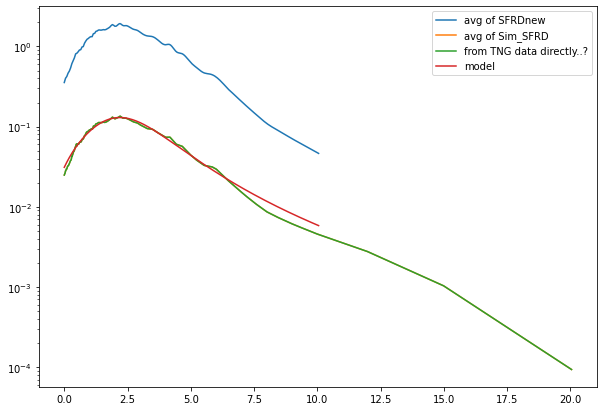

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

plt.plot(redshift_new, np.sum(SFRDnew*step_fit_logZ,axis=0), label='avg of SFRDnew')
plt.plot(Redshifts, np.sum(Sim_SFRD*step_fit_logZ, axis=1), label='avg of Sim_SFRD')
plt.plot(redshifts_TNG, np.sum(TNG_SFRD, axis=1), label='from TNG data directly..?')
plt.plot(redshift_new, sfr, label='model')
plt.yscale('log')
plt.legend();

## Write SFRD(Z, z) data to files

In [391]:
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

# Retrieve values at higher res regular intervals
redshift_COMPAS         = np.arange(0, 14.05, 0.05)
Lookbacktimes_COMPAS    = [cosmo.lookback_time(z).value for z in redshift_COMPAS]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500) #500 metal values
log_metallicities_c = np.arange(-6, 0 + step_logZ, 0.01)
metallicities_c = 10**(log_metallicities_c)

SFRD_COMPAS = f_interp(Lookbacktimes_COMPAS,metals_new)
SFRD_COMPAS[SFRD_COMPAS < 0] = 0 #make sure there are no unphysical values of the SFRD

In [392]:
metals_new

array([1.23389963e-06, 1.26756396e-06, 1.30214674e-06, 1.33767304e-06,
       1.37416861e-06, 1.41165987e-06, 1.45017400e-06, 1.48973892e-06,
       1.53038327e-06, 1.57213652e-06, 1.61502892e-06, 1.65909154e-06,
       1.70435632e-06, 1.75085606e-06, 1.79862444e-06, 1.84769608e-06,
       1.89810653e-06, 1.94989233e-06, 2.00309099e-06, 2.05774106e-06,
       2.11388215e-06, 2.17155492e-06, 2.23080117e-06, 2.29166383e-06,
       2.35418700e-06, 2.41841598e-06, 2.48439731e-06, 2.55217881e-06,
       2.62180957e-06, 2.69334006e-06, 2.76682211e-06, 2.84230897e-06,
       2.91985531e-06, 2.99951735e-06, 3.08135280e-06, 3.16542095e-06,
       3.25178272e-06, 3.34050069e-06, 3.43163914e-06, 3.52526411e-06,
       3.62144343e-06, 3.72024681e-06, 3.82174582e-06, 3.92601402e-06,
       4.03312695e-06, 4.14316224e-06, 4.25619960e-06, 4.37232094e-06,
       4.49161041e-06, 4.61415444e-06, 4.74004182e-06, 4.86936377e-06,
       5.00221399e-06, 5.13868875e-06, 5.27888694e-06, 5.42291013e-06,
      

In [393]:
log_metallicities_c

array([-6.00000000e+00, -5.99000000e+00, -5.98000000e+00, -5.97000000e+00,
       -5.96000000e+00, -5.95000000e+00, -5.94000000e+00, -5.93000000e+00,
       -5.92000000e+00, -5.91000000e+00, -5.90000000e+00, -5.89000000e+00,
       -5.88000000e+00, -5.87000000e+00, -5.86000000e+00, -5.85000000e+00,
       -5.84000000e+00, -5.83000000e+00, -5.82000000e+00, -5.81000000e+00,
       -5.80000000e+00, -5.79000000e+00, -5.78000000e+00, -5.77000000e+00,
       -5.76000000e+00, -5.75000000e+00, -5.74000000e+00, -5.73000000e+00,
       -5.72000000e+00, -5.71000000e+00, -5.70000000e+00, -5.69000000e+00,
       -5.68000000e+00, -5.67000000e+00, -5.66000000e+00, -5.65000000e+00,
       -5.64000000e+00, -5.63000000e+00, -5.62000000e+00, -5.61000000e+00,
       -5.60000000e+00, -5.59000000e+00, -5.58000000e+00, -5.57000000e+00,
       -5.56000000e+00, -5.55000000e+00, -5.54000000e+00, -5.53000000e+00,
       -5.52000000e+00, -5.51000000e+00, -5.50000000e+00, -5.49000000e+00,
       -5.48000000e+00, -

In [394]:
np.exp(-6)

0.0024787521766663585

In [395]:
metallicities_c

array([0.00247875, 0.00250366, 0.00252883, 0.00255424, 0.00257991,
       0.00260584, 0.00263203, 0.00265848, 0.0026852 , 0.00271219,
       0.00273944, 0.00276698, 0.00279479, 0.00282287, 0.00285124,
       0.0028799 , 0.00290884, 0.00293808, 0.00296761, 0.00299743,
       0.00302755, 0.00305798, 0.00308872, 0.00311976, 0.00315111,
       0.00318278, 0.00321477, 0.00324708, 0.00327971, 0.00331267,
       0.00334597, 0.00337959, 0.00341356, 0.00344787, 0.00348252,
       0.00351752, 0.00355287, 0.00358858, 0.00362464, 0.00366107,
       0.00369786, 0.00373503, 0.00377257, 0.00381048, 0.00384878,
       0.00388746, 0.00392653, 0.00396599, 0.00400585, 0.00404611,
       0.00408677, 0.00412784, 0.00416933, 0.00421123, 0.00425356,
       0.0042963 , 0.00433948, 0.0043831 , 0.00442715, 0.00447164,
       0.00451658, 0.00456197, 0.00460782, 0.00465413, 0.00470091,
       0.00474815, 0.00479587, 0.00484407, 0.00489275, 0.00494193,
       0.00499159, 0.00504176, 0.00509243, 0.00514361, 0.00519

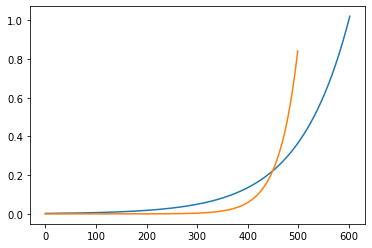

In [396]:
plt.plot(metallicities_c)
plt.plot(metals_new)

In [397]:
print(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals))

-5.908720164658326 -0.07538683132499271


In [374]:
print(min(metals_new), max(metals_new))

1.233899633811034e-06 0.8406460345289797


In [375]:
print(min(metallicities_c), max(metallicities_c))

0.0024787521766663585 1.020201340026625


In [343]:
redshift_COMPAS

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
        4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
        4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
        5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
        5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
        6.3 ,  6.35,

In [344]:
# Read out data
np.savetxt(SFRD_Z_z_fname, SFRD_COMPAS)
np.savetxt(metals_fname, metals_new)

In [345]:
# Check whether can read in data correctly
SFRD_Z_z_test = np.loadtxt(SFRD_Z_z_fname)
metallicities_test = np.loadtxt(metals_fname)

In [346]:
np.where((SFRD_Z_z_test == SFRD_COMPAS) == False)

(array([], dtype=int64), array([], dtype=int64))

In [347]:
SFRD_Z_z_test.shape

(500, 281)

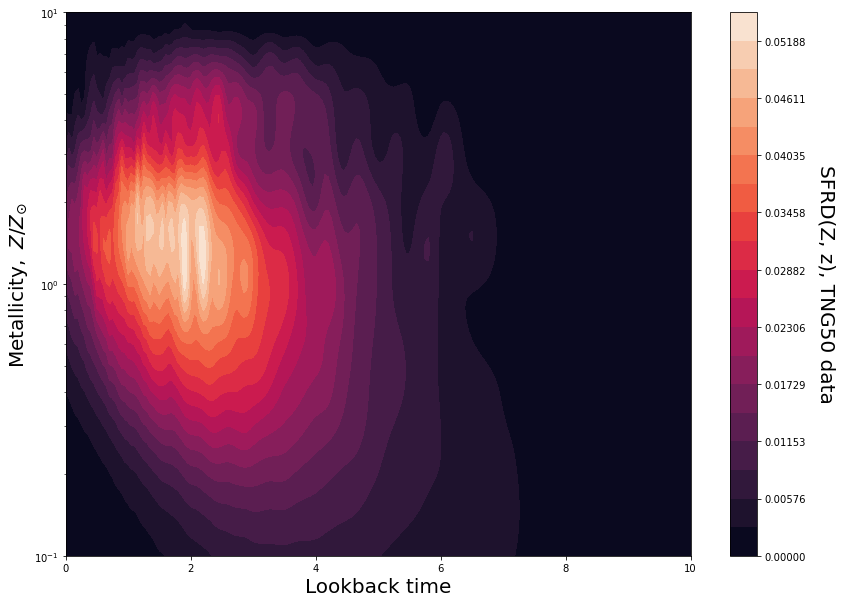

In [348]:
fig, ax = plt.subplots(figsize = (14,10))

levels = np.linspace(np.amin(SFRD_Z_z_test), np.amax(SFRD_Z_z_test), 20)
#levels = np.linspace(0, 0.055, 20)

data = ax.contourf(redshift_COMPAS, metallicities_test/Zsun, SFRD_Z_z_test, levels=levels, cmap=cmap)

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.set_ylim(10**-1, 10**1)
ax.set_xlim(0, 10)

"""
ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10,14]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
ax2.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
"""

cbar = fig.colorbar(data)
if ver>1:
    cbar.set_label('SFRD(Z, z), TNG%s-%s data'%(tng, ver), rotation=270, fontsize=20, labelpad=30);
else:
    cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30);

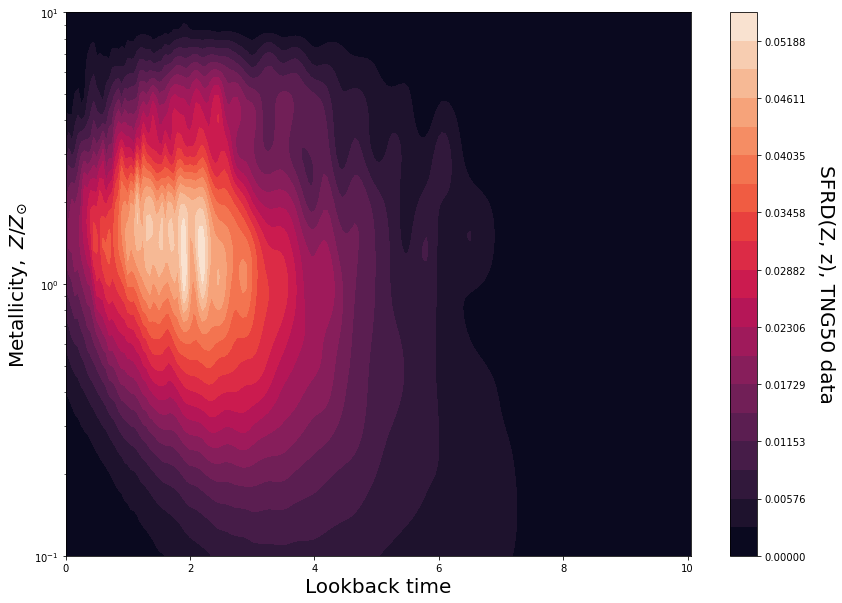

In [349]:
fig, ax = plt.subplots(figsize = (14,10))

levels = np.linspace(np.amin(SFRDnew), np.amax(SFRDnew), 20)
#levels = np.linspace(0, 0.055, 20)

data = ax.contourf(redshift_new, metals_new/Zsun, SFRDnew, levels=levels, cmap=cmap)

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.set_ylim(10**-1, 10**1)

"""
ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10,14]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
ax2.set_xlim(min(Lookbacktimes_COMPAS), max(Lookbacktimes_COMPAS))
"""

cbar = fig.colorbar(data)
if ver>1:
    cbar.set_label('SFRD(Z, z), TNG%s-%s data'%(tng, ver), rotation=270, fontsize=20, labelpad=30);
else:
    cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30);

In [354]:
# Get the SFR (Shape of Madau & Fragos 2014)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_new, a=sf_a, b=sf_b, c=sf_c, d=sf_d).value # Msun year-1 Mpc-3 
# Get dPdZ (skew-log-normal distribution)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshift_new ,mu_z = muz , mu_0 = mu0 ,
                                                  omega_0= omega0 , omega_z=omegaz , alpha = alpha , 
                                                  metals=metals_new)
    

model = sfr[:,np.newaxis] * dPdlogZ

In [355]:
model

array([[1.09555011e-23, 1.41174371e-23, 1.81800265e-23, ...,
        6.81023131e-10, 5.14881040e-10, 3.88341985e-10],
       [2.50726844e-23, 3.21833138e-23, 4.12838391e-23, ...,
        9.10968044e-10, 6.91531737e-10, 5.23720635e-10],
       [5.65147150e-23, 7.22642763e-23, 9.23441635e-23, ...,
        1.21014621e-09, 9.22324884e-10, 7.01333429e-10],
       ...,
       [2.82806615e-04, 2.85363934e-04, 2.87934894e-04, ...,
        2.00514074e-05, 1.95261583e-05, 1.90126878e-05],
       [2.87632585e-04, 2.90176234e-04, 2.92732824e-04, ...,
        1.96305229e-05, 1.91199752e-05, 1.86207958e-05],
       [2.92426952e-04, 2.94955393e-04, 2.97496075e-04, ...,
        1.92161513e-05, 1.87199269e-05, 1.82346747e-05]])

In [356]:
nformed = sfr/0.13123123123
model2 = nformed[:,np.newaxis] * dPdlogZ

In [357]:
model/0.13123123123

array([[8.34824227e-23, 1.07576809e-22, 1.38534298e-22, ...,
        5.18948976e-09, 3.92346422e-09, 2.95921925e-09],
       [1.91057298e-22, 2.45241270e-22, 3.14588522e-22, ...,
        6.94170157e-09, 5.26956678e-09, 3.99082315e-09],
       [4.30649888e-22, 5.50663707e-22, 7.03675204e-22, ...,
        9.22148026e-09, 7.02824225e-09, 5.34425702e-09],
       ...,
       [2.15502524e-03, 2.17451236e-03, 2.19410342e-03, ...,
        1.52794478e-04, 1.48792007e-04, 1.44879291e-04],
       [2.19179979e-03, 2.21118274e-03, 2.23066431e-03, ...,
        1.49587280e-04, 1.45696836e-04, 1.41893020e-04],
       [2.22833352e-03, 2.24760060e-03, 2.26696094e-03, ...,
        1.46429712e-04, 1.42648413e-04, 1.38950725e-04]])

In [358]:
model2

array([[8.34824227e-23, 1.07576809e-22, 1.38534298e-22, ...,
        5.18948976e-09, 3.92346422e-09, 2.95921925e-09],
       [1.91057298e-22, 2.45241270e-22, 3.14588522e-22, ...,
        6.94170157e-09, 5.26956678e-09, 3.99082315e-09],
       [4.30649888e-22, 5.50663707e-22, 7.03675204e-22, ...,
        9.22148026e-09, 7.02824225e-09, 5.34425702e-09],
       ...,
       [2.15502524e-03, 2.17451236e-03, 2.19410342e-03, ...,
        1.52794478e-04, 1.48792007e-04, 1.44879291e-04],
       [2.19179979e-03, 2.21118274e-03, 2.23066431e-03, ...,
        1.49587280e-04, 1.45696836e-04, 1.41893020e-04],
       [2.22833352e-03, 2.24760060e-03, 2.26696094e-03, ...,
        1.46429712e-04, 1.42648413e-04, 1.38950725e-04]])